In [1]:
import warnings
warnings.filterwarnings('ignore')

## SpLit data Train_After_Selection

In [2]:
import pandas as pd
df = pd.read_csv('../dataset/after_selection/train.csv')
X = df.drop(columns=['Response'])
y = df[['Response']]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [3]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 63217 entries, 19573 to 15795
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Driving_License                 63217 non-null  int64  
 1   Region_Code                     63217 non-null  float64
 2   Previously_Insured              63217 non-null  int64  
 3   Vehicle_Age                     63217 non-null  int64  
 4   Vehicle_Damage                  63217 non-null  int64  
 5   Policy_Sales_Channel            63217 non-null  float64
 6   Age_Bin                         63217 non-null  int64  
 7   Vehicle_Damage_Age_Interaction  63217 non-null  int64  
dtypes: float64(2), int64(6)
memory usage: 4.3 MB


### Melihat distribusi data target

In [4]:
df.Response.value_counts(normalize=False)

Response
0    45155
1    45155
Name: count, dtype: int64

## model evaluasi dan feature importance

In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_validate, StratifiedKFold

def eval_classification(model, X_train, X_test, y_train, y_test, n_splits=5):
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    y_pred_proba_train = model.predict_proba(X_train)
    y_pred_proba_test = model.predict_proba(X_test)
    # StratifiedKFold for cross-validation with stratified sampling
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    # Perform cross-validation
    cv_test_results = cross_validate(model, X_test, y_test, scoring=['roc_auc'],
                                cv=cv, return_train_score=False)
    cv_train_results = cross_validate(model, X_train, y_train, scoring=['roc_auc'],
                                cv=cv, return_train_score=False)
    
    # Evaluation train
    print("\nTraining Set:")
    print("Accuracy: %.2f" % accuracy_score(y_train, y_pred_train))
    print("Precision: %.2f" % precision_score(y_train, y_pred_train))
    print("Recall: %.2f" % recall_score(y_train, y_pred_train))
    print("F1-Score: %.2f" % f1_score(y_train, y_pred_train))
    print("ROC AUC: %.2f" % roc_auc_score(y_train, y_pred_proba_train[:, 1]))
    
    # Evaluation test
    print("\nTest Set:")
    print("Accuracy: %.2f" % accuracy_score(y_test, y_pred_test))
    print("Precision: %.2f" % precision_score(y_test, y_pred_test))
    print("Recall: %.2f" % recall_score(y_test, y_pred_test))
    print("F1-Score: %.2f" % f1_score(y_test, y_pred_test))
    print("ROC AUC: %.2f" % roc_auc_score(y_test, y_pred_proba_test[:, 1]))

    # Display cross-validation results
    print("\nMetrics Using Cross Validation:")
    print(f"Mean ROC-AUC (Test): {cv_test_results['test_roc_auc'].mean():.2f}")
    print(f"Std ROC-AUC (Test): {cv_test_results['test_roc_auc'].std():.2f}")
    print()
    print(f"Mean ROC-AUC (Train): {cv_train_results['test_roc_auc'].mean():.2f}")
    print(f"Std ROC-AUC (Train): {cv_train_results['test_roc_auc'].std():.2f}")

def show_feature_importance(model):
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(10, 8))
    ax.invert_yaxis()

    plt.xlabel('score')
    plt.ylabel('feature')
    plt.title('feature importance score')



#

## Model AdaBoostClassifier dan hasil prediksi

In [15]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier()
clf.fit(X_train, y_train)
eval_classification(clf,X_train, X_test, y_train, y_test)

Training Set:
Accuracy: 0.80
Precision: 0.73
Recall: 0.95
F1-Score: 0.82
ROC AUC: 0.85

Test Set:
Accuracy: 0.80
Precision: 0.73
Recall: 0.95
F1-Score: 0.82
ROC AUC: 0.84

Metrics Using Cross Validation:
Mean ROC-AUC (Test): 0.84
Std ROC-AUC (Test): 0.00

Mean ROC-AUC (Train): 0.85
Std ROC-AUC (Train): 0.00


## Hyperparameter Tuning

In [27]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import numpy as np

# List of hyperparameter
hyperparameters = dict(n_estimators = [int(x) for x in np.linspace(start = 50, stop = 200, num = 200)],
                       learning_rate = [float(x) for x in np.linspace(start = 0.001, stop = 0.1, num = 200)],  
                       algorithm = ['SAMME', 'SAMME.R']
                      )

# Init model
ab = AdaBoostClassifier(random_state=42)
ab_tuned = RandomizedSearchCV(ab, hyperparameters, random_state=42, cv=5, scoring='recall')
ab_tuned.fit(X_train,y_train)

print(f'Best Hyperparameters: {ab_tuned.best_params_}')

# Predict & Evaluation
eval_classification(ab_tuned, X_train, X_test, y_train, y_test)

Best Hyperparameters: {'n_estimators': 98, 'learning_rate': 0.016422110552763818, 'algorithm': 'SAMME'}

Training Set:
Accuracy: 0.76
Precision: 0.68
Recall: 1.00
F1-Score: 0.81
ROC AUC: 0.82

Test Set:
Accuracy: 0.76
Precision: 0.67
Recall: 1.00
F1-Score: 0.80
ROC AUC: 0.82

Metrics Using Cross Validation:
Mean ROC-AUC (Test): 0.81
Std ROC-AUC (Test): 0.02

Mean ROC-AUC (Train): 0.82
Std ROC-AUC (Train): 0.00


In [24]:

print(f'Best Hyperparameters: {ab_tuned.best_params_}')


Best Hyperparameters: {'n_estimators': 98, 'learning_rate': 0.016422110552763818, 'algorithm': 'SAMME'}


In [25]:
eval_classification(ab_tuned, X_train, X_test, y_train, y_test)

## Score Feature importance

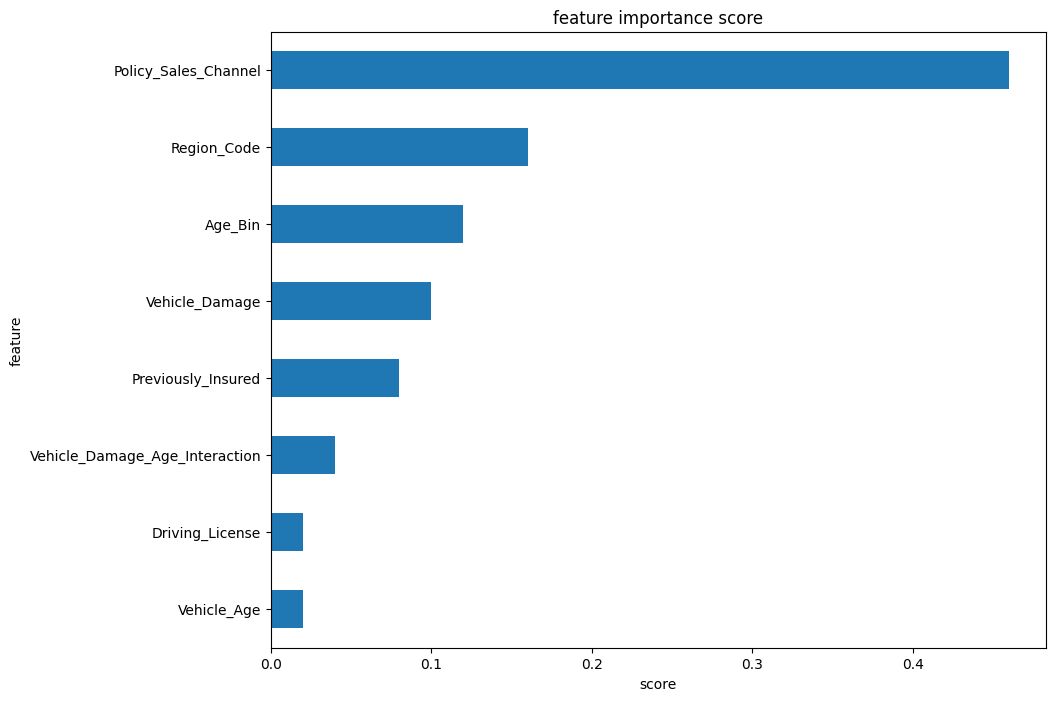

In [8]:
show_feature_importance(clf)